
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

## Problem Statement:
### Given the Iowa Liquor Sales dataset, the goal is to determine the best location for a new store based on store performance. Models will be created for breakdowns by city, county, and zip code. Whichever model achieves the lowest MSE (along with a high Rsquared score) will be used to select stores and assess their performance. Stores will receive predicted sales for 2015 and 2016, along with the actual sales for 2015 for comparison.


In [3]:
import pandas as pd

import numpy as np
## Load the data into a DataFrame
liquor = pd.read_csv('../../../../Data/Iowa_Liquor_sales_sample_10pct.csv')[['Store Number',
               'Date',
               'City',
               'Zip Code',
               'County Number',
               'County',
               'Bottle Volume (ml)', 
               'State Bottle Cost', 
               'State Bottle Retail', 
               'Bottles Sold', 
               'Sale (Dollars)', 
               'Volume Sold (Liters)', 
               'Volume Sold (Gallons)']]


In [6]:
## Make necessary column modifications

## Transform the dates
liquor["Date"] = pd.to_datetime(liquor["Date"], format="%m/%d/%Y")
liquor["Year"] = liquor.Date.dt.year
liquor["Month"] = liquor.Date.dt.month

## I'm creating functions for a few different things
## that I'll be able to reuse when I import the full dataset
def  clean_columns(table):
    table.columns = [x.replace(' ', '_') for x in table.columns]
    table.columns = [x.replace(')', '') for x in table.columns]
    table.columns = [x.replace('(', '') for x in table.columns]
    table.columns = [x.lower()  for x in table.columns]  
    table.city = liquor.city.str.upper()   #capitalize all cities and counties
    table.county = table.county.str.upper()
    ## remove dollar sign from monetary columns and convert to float
    for column in ('sale_dollars', 'state_bottle_retail', 'state_bottle_cost'):
        table[column] = table[column].str.replace('$','').astype(np.float64)
    ## convert to float
    table['bottles_sold'] = table['bottles_sold'].astype(np.float64)

clean_columns(liquor)

In [3]:
## check: missing values, dtypes, df shape, describe, unique values, duplicates

def eda(dataframe):
    
    print "missing values \n", dataframe.isnull().sum()## count number of null values per column
    print ''
    print "dataframe types \n", dataframe.dtypes       ## list data type of each column
    print ''
    print "dataframe shape \n", dataframe.shape        ## rows by columns
    print ''
    print "dataframe describe \n", dataframe.describe()## stats -- mean, min, max, etc.. 
    print ''
    for item in dataframe:                             ## count number of unique values per column
        print item, '= ', dataframe[item].nunique()
    print ''
    print 'num duplicates:', dataframe.duplicated().sum()

# eda(liquor)

In [4]:
## As a result of the EDA function, 
## I will drop duplicates
## & fill in county names

## drop duplicate rows
liquor.drop_duplicates(inplace=True)
print 'num duplicates:', liquor.duplicated().sum()

## create a lookup table for all filled in counties, zip_codes
## that can be used to fill in any counties have a zip code but no name
county_lookup = liquor[['zip_code','county']][liquor.county.isnull()==False]
county_lookup.drop_duplicates(inplace=True)   # make sure there's only one of each county, drop dupes

## in addition to the lookup table, I'm using the file below
## to help fill in missing county names
iowa_zips = pd.read_csv('../../../../Data/iowa_zips.csv')
iowa_zips.columns = [c.replace(' ', '_') for c in iowa_zips.columns]

## next cell will update county names

num duplicates: 0


In [5]:
## I spent a while trying to figure out how to update
## values in the pandas dataframe, but was very
## unsuccessful. I decided to run the updates using SQL instead.

## set up connection to SQLalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
conn = engine.connect()

## push dataframes into sql tables
liquor.to_sql('liquor', engine)
county_lookup.to_sql('county_lookup', engine)
iowa_zips.to_sql('iowa_zips', engine)

## run updates to fill in county names by matching zip_codes to lookup data
q1 = 'update liquor set county = (select upper(county) from county_lookup where county_lookup.zip_code = liquor.zip_code) where county is null;'
q2 = 'update liquor set county = (select upper(County) from iowa_zips where iowa_zips.Zip_Code = liquor.zip_code) where county is null;'
q3 = 'update liquor set county = null where zip_code not in (select Zip_Code from iowa_zips) ;'

conn.execute(q1)
conn.execute(q2)

## pull sql table back into a pandas df
liquor = pd.read_sql_table('liquor',engine)

## close sql connection
conn.close()

eda(liquor)

missing values 
index                     0
store_number              0
date                      0
city                      0
zip_code                  0
county_number          1061
county                    0
bottle_volume_ml          0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sale_dollars              0
volume_sold_liters        0
volume_sold_gallons       0
year                      0
month                     0
dtype: int64

dataframe types 
index                           int64
store_number                    int64
date                   datetime64[ns]
city                           object
zip_code                       object
county_number                 float64
county                         object
bottle_volume_ml                int64
state_bottle_cost             float64
state_bottle_retail           float64
bottles_sold                  float64
sale_dollars                  float64
volume_sold_liters            float64
volume_sold

In [6]:
## all are filled in!

## and now i'll export the data to be used for mapping in tableau
# liquor.to_csv('../../../../Iowa_Liquor_sales_sample_10pct_CLEAN.csv') 

## because i'm neurotic, found coordinates for counties that couldn't be mapped in tableau
# https://dom.iowa.gov/document/iowa-county-codes-and-coordinates

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

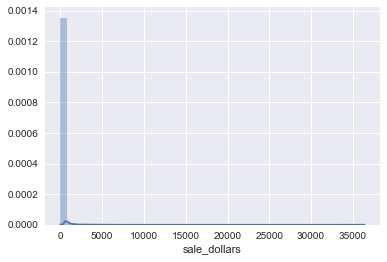

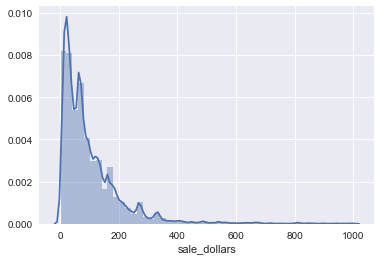

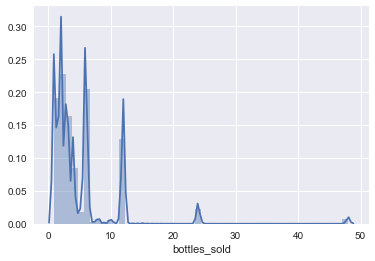

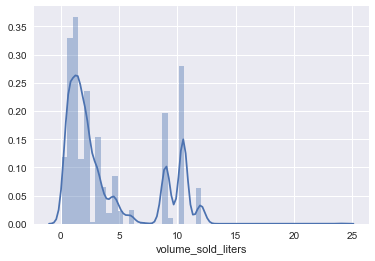

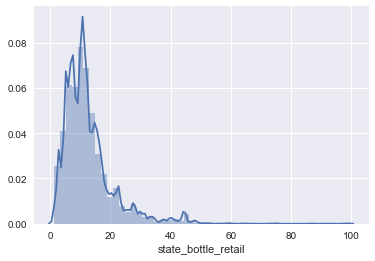

In [8]:
## to see what we're daeling with, plot the sale_dollars, bottles_sold, state_bottle_retail
## filters on sale_dollar amounts leave out outliers to get a closer view of the rest of the data

sns.distplot(liquor['sale_dollars'])
plt.show()
sns.distplot(liquor['sale_dollars'][liquor.sale_dollars <1000])
plt.show()
sns.distplot(liquor['bottles_sold'][liquor.sale_dollars <100])
plt.show()
sns.distplot(liquor['volume_sold_liters'][liquor.sale_dollars <100])
plt.show()
sns.distplot(liquor['state_bottle_retail'][liquor.sale_dollars <100])
plt.show()

From these graphs, it appears that state_bottle_retail, volume_sold_liters, and bottles_sold could have some sort of relationship, so I'll try to explore that further to see if they are what I should build my model on.

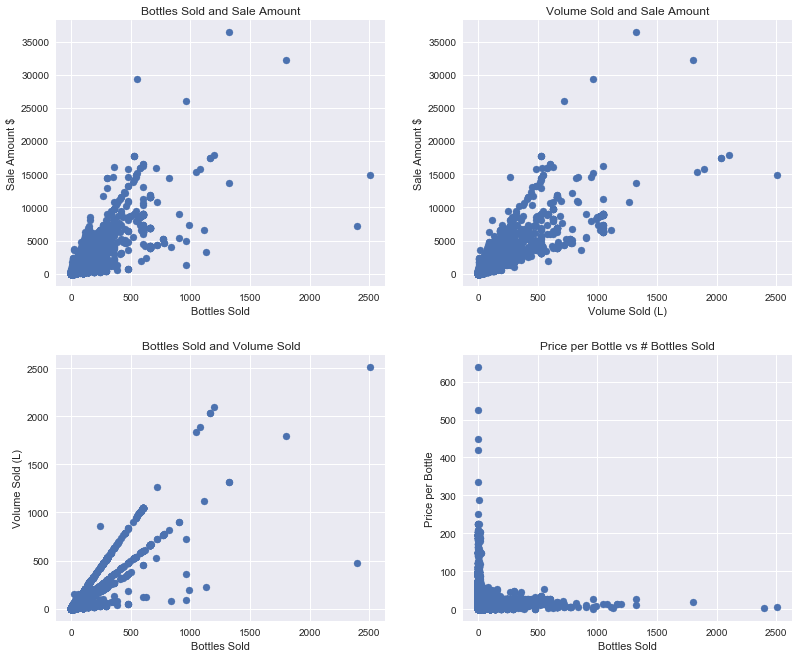

In [9]:
# to begin looking at possible features to select, create scatter plots of various variable relationships
plt.close('all')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
plt.tight_layout(pad=5, w_pad=5, h_pad=5)

ax1.scatter(liquor.bottles_sold,liquor.sale_dollars)
ax1.set_xlabel('Bottles Sold')
ax1.set_ylabel('Sale Amount $')
ax1.set_title('Bottles Sold and Sale Amount')

ax2.scatter(liquor.volume_sold_liters,liquor.sale_dollars)
ax2.set_xlabel('Volume Sold (L)')
ax2.set_ylabel('Sale Amount $')
ax2.set_title('Volume Sold and Sale Amount')

ax3.scatter(liquor.bottles_sold,liquor.volume_sold_liters)
ax3.set_xlabel('Bottles Sold')
ax3.set_ylabel('Volume Sold (L)')
ax3.set_title('Bottles Sold and Volume Sold')

ax4.scatter(liquor.bottles_sold,liquor.state_bottle_retail)
ax4.set_xlabel('Bottles Sold')
ax4.set_ylabel('Price per Bottle')
ax4.set_title('Price per Bottle vs # Bottles Sold')



These graphs indicate:
1) Bottles Sold vs Sale Amount $: this isn't surprising, but the number of bottles sold affects the sale amount
2) Price per bottle vs Bottles Sold: Stores seem to be selling much more of the lesser expensive alochol than the very pricey bottles
3) Bottles Sold vs Volume Sold: Generally, volume and bottles go hand in hand, but the slope of the two major lines indicate that generally the number of bottles sold is lower than the number of liters, which just means that most bottles are over a liter.
4) Volume Sold and Sale Amount: Pretty similar to the first graph, showing that the more that is sold, the more the sales increase.

# Record your findings

Be sure to write out any observations from your exploratory analysis.


First off, I want to note that the column being used, state_bottle_retail, does NOT reflect the sales of the store--this figure is the amount that they paid to the state for their inventory. These analyses then are assuming that they're selling what they buy.

I'm definitely interested to see what profits are being made and breaking some of the features down. Overall, nothing surprising was uncovered through initial exploratory analysis.

For outliers, each of my graphs clearly shows that there are a few data points with sales > 20000, so I will exclude them.

# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.
 


In [8]:
# exclude the sales >+ 20000 as determined by graphs
liquor = liquor[liquor.sale_dollars < 20000]

# create a column for 2015 sales, and both 2015, 2016 Q1 sales
# I plan to include 2015Q1 as a feature and then run 2016Q1 to predict what 2016 FY sales will be
liquor['sales_2015'] = liquor['sale_dollars'][liquor.year==2015]
liquor['sales_1Q15'] = liquor['sale_dollars'][liquor.year==2015 ][liquor.month.isin([1,2,3])]
liquor['sales_1Q16'] = liquor['sale_dollars'][liquor.year==2016 ][liquor.month.isin([1,2,3])]

In [11]:
# To figure out whether I look for the best location by zip, city, or county, 
# I'll build a model for each and choose what I think is best

aggs = {'bottles_sold': np.sum, 'volume_sold_liters': np.sum, 'state_bottle_retail' : np.sum, 'sales_2015' : np.sum, 'sales_1Q15' : np.sum, 'sales_1Q16' : np.sum, 'store_number' : pd.Series.nunique}
aggs_store = {'bottles_sold': np.sum, 'volume_sold_liters': np.sum, 'state_bottle_retail' : np.sum, 'sales_2015' : np.sum, 'sales_1Q15' : np.sum, 'sales_1Q16' : np.sum}
# create a sub-df of liquor to see figures on the store level
liquor_by_store = liquor[['store_number',
                          'sales_2015',
                          'sales_1Q15',
                          'sales_1Q16',                          
                          'bottles_sold', 
                          'volume_sold_liters',
                          'state_bottle_retail']].groupby(liquor.store_number).agg(aggs_store)

# create a sub-df of liquor to see figures on the zip_code level
liquor_by_zip = liquor[['zip_code',
                          'sales_2015',
                          'sales_1Q15',
                          'sales_1Q16',                          
                          'bottles_sold', 
                          'state_bottle_retail',
                        'volume_sold_liters',
                       'store_number']].groupby(liquor.zip_code).agg(aggs)

# create a sub-df of liquor to see figures on the city level
liquor_by_city = liquor[['city',
                          'sales_2015',
                          'sales_1Q15',
                          'sales_1Q16',                          
                          'bottles_sold', 
                          'state_bottle_retail',
                         'volume_sold_liters',
                        'store_number']].groupby(liquor.city).agg(aggs)

# create a sub-df of liquor to see figures on the county level
liquor_by_county = liquor[['county',
                          'sales_2015',
                          'sales_1Q15',
                          'sales_1Q16',                          
                          'bottles_sold', 
                          'state_bottle_retail',
                           'volume_sold_liters',
                          'store_number']].groupby(liquor.county).agg(aggs)


liquor_by_zip.fillna(0,inplace=True)
liquor_by_city.fillna(0,inplace=True)
liquor_by_county.fillna(0,inplace=True)

# add some more stats to the tables to consider for feature selection
for liquor_table in (liquor_by_zip, liquor_by_city, liquor_by_county, liquor_by_store):
    liquor_table['avg_price_per_bottle'] = liquor_table.sales_2015 / liquor_table.bottles_sold
    liquor_table['avg_price_per_liter'] = liquor_table.sales_2015 / liquor_table.volume_sold_liters


# Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

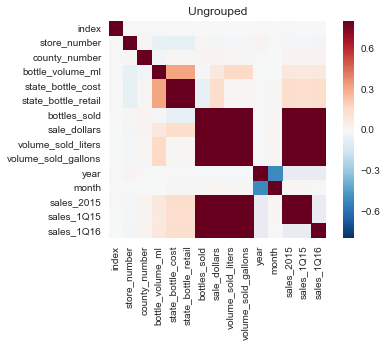

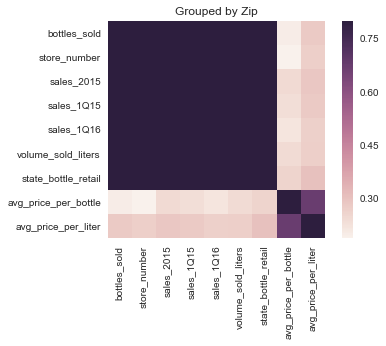

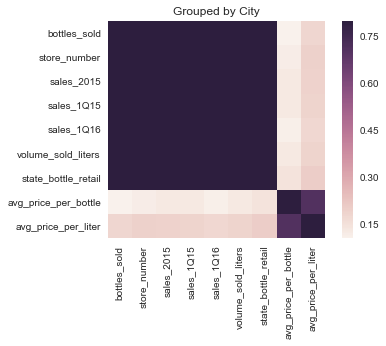

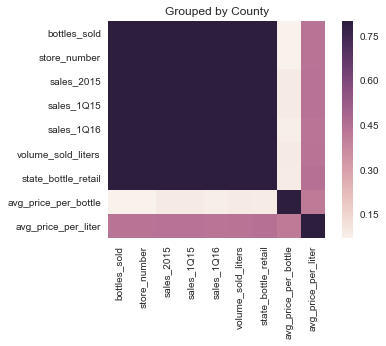

In [12]:
# now that we have some more features, look at the correlation between variables for each breakdown

liquor_correlation = liquor.corr()
sns.heatmap(liquor_correlation, vmax=.8, square=True)
plt.title('Ungrouped')
plt.show()

liquor_zip_correlation = liquor_by_zip.corr()
sns.heatmap(liquor_zip_correlation, vmax=.8, square=True)
plt.title('Grouped by Zip')
plt.show()

liquor_city_correlation = liquor_by_city.corr()
sns.heatmap(liquor_city_correlation, vmax=.8, square=True)
plt.title('Grouped by City')
plt.show()
liquor_county_correlation = liquor_by_county.corr()
sns.heatmap(liquor_county_correlation, vmax=.8, square=True)
plt.title('Grouped by County')
plt.show()


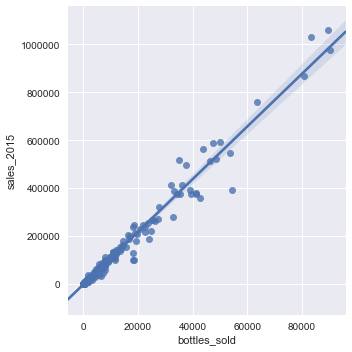

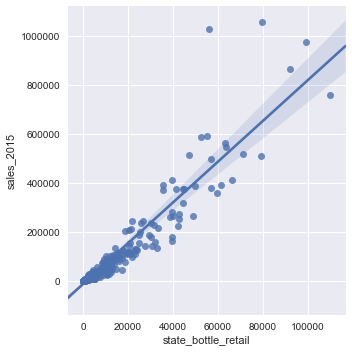

In [13]:
sns.lmplot(x="bottles_sold", y="sales_2015", data=liquor_by_zip)
sns.lmplot(x="state_bottle_retail", y="sales_2015", data=liquor_by_zip)

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [9]:
import statsmodels.formula.api as sm #import statsmodels
from sklearn import linear_model, metrics


Zip code model:  training set score =  0.977372267512  //  MSE =  13641.5746305

City model:      training set score =  0.958515256638  //  MSE =  22769.9967643

County model:    training set score =  0.997791593677  //  MSE =  12776.4916163


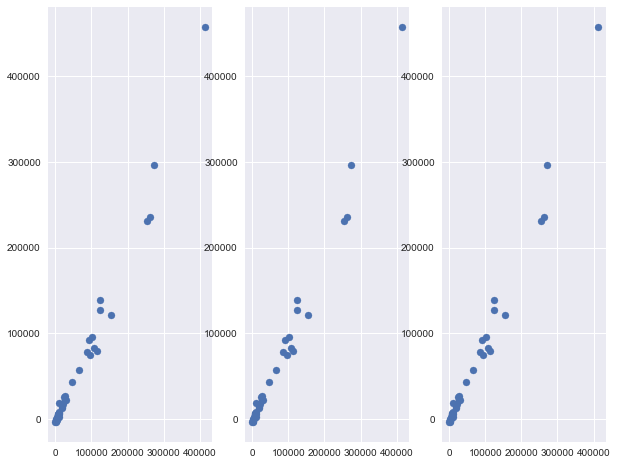

In [15]:
## Build a separate model for each zip, city, and county grouped sub-dfs
# features      = [u'bottles_sold', u'volume_sold_liters', u'state_bottle_retail', u'avg_price_per_liter','avg_price_per_bottle','sales_1Q15']

features      = ['bottles_sold','state_bottle_retail','sales_1Q15']

alpha_range    = 10.**np.arange(-2, 3)

liquor_by_zip.fillna(0,inplace=True)
liquor_by_city.fillna(0,inplace=True)
liquor_by_county.fillna(0,inplace=True)

# define the subsets that we'll use to train the models
subset_zip     = liquor_by_zip.sample(frac=0.1, replace=False) 
subset_city    = liquor_by_city.sample(frac=0.1, replace=False) 
subset_county  = liquor_by_county.sample(frac=0.1, replace=False) 

# define the training data for each model
X_train_zip    = subset_zip[features]
y_train_zip    = subset_zip['sales_2015']
X_train_city   = subset_city[features]
y_train_city   = subset_city['sales_2015']
X_train_county = subset_county[features]
y_train_county = subset_county['sales_2015']

lm = linear_model.RidgeCV(alphas=alpha_range) # Try different alphas 

model_by_zip = lm.fit(X_train_zip, y_train_zip) #and then fit a line WITH REGULARIZATION
model_by_city = lm.fit(X_train_city, y_train_city)
model_by_county = lm.fit(X_train_county, y_train_county)

predictions_train_zip = model_by_zip.predict(X_train_zip) #we then generate predicted values _just based on the X_ 
predictions_train_city = model_by_city.predict(X_train_city) #we then generate predicted values _just based on the X_ 
predictions_train_county = model_by_county.predict(X_train_county) #we then generate predicted values _just based on the X_ 

zip_train_score = model_by_zip.score(X_train_zip, y_train_zip)
city_train_score = model_by_city.score(X_train_city, y_train_city)
county_train_score = model_by_county.score(X_train_county, y_train_county)

zip_train_mse = np.sqrt(metrics.mean_squared_error(y_train_zip, predictions_train_zip))
city_train_mse = np.sqrt(metrics.mean_squared_error(y_train_city, predictions_train_city))
county_train_mse = np.sqrt(metrics.mean_squared_error(y_train_county, predictions_train_county))

print 'Zip code model:  training set score = ', zip_train_score, ' //  MSE = ', zip_train_mse
print ''
print 'City model:      training set score = ', city_train_score, ' //  MSE = ', city_train_mse
print ''
print 'County model:    training set score = ', county_train_score, ' //  MSE = ', county_train_mse

plt.close('all')
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3,figsize=(10,8))

ax1.scatter(y_train_zip,predictions_train_zip)
ax2.scatter(y_train_zip,predictions_train_zip)
ax3.scatter(y_train_zip,predictions_train_zip)


In [16]:
# Apply to the whole data set
X_zip = liquor_by_zip[features]
y_zip = liquor_by_zip['sales_2015']
X_city = liquor_by_city[features]
y_city = liquor_by_city['sales_2015']
X_county = liquor_by_county[features]
y_county = liquor_by_county['sales_2015']

zip_score = model_by_zip.score(X_zip, y_zip)
city_score = model_by_city.score(X_city, y_city)
county_score = model_by_county.score(X_county, y_county)

zip_predictions = model_by_zip.predict(X_zip)
city_predictions = model_by_city.predict(X_city)
county_predictions = model_by_county.predict(X_county)

zip_mse = np.sqrt(metrics.mean_squared_error(y_zip, zip_predictions))
city_mse = np.sqrt(metrics.mean_squared_error(y_city, city_predictions))
county_mse = np.sqrt(metrics.mean_squared_error(y_county, county_predictions))

print 'Zip code model:  full df score = ', zip_score, '  //  MSE = ', zip_mse
print ''
print 'City model:      full df score = ', city_score, '  //  MSE = ', city_mse
print ''
print 'County model:    full df score = ', county_score, '  //  MSE = ', county_mse



Zip code model:  full df score =  0.984495229418   //  MSE =  17851.1163081

City model:      full df score =  0.992991509697   //  MSE =  21748.2849178

County model:    full df score =  0.992473781526   //  MSE =  63900.8854384


I've decided to go with zip code as my location factor because its MSE is lowest for both train and full datasets. I think that having many more zip codes than cities or counties helps with the model. I'm also afraid of 99% scores and assume it must be overfit.

Next, I'll take the top zipcode by predicted performance and use that to find the best performing stores.

In [17]:
liquor_by_zip['predictions_2015fy'] = model_by_zip.predict(X_zip)
liquor_by_zip['predictions_2016fy'] = model_by_zip.predict(liquor_by_zip[['bottles_sold','state_bottle_retail','sales_1Q16']])

liquor_by_zip[['predictions_2016fy','predictions_2015fy','sales_2015']].sort_values('predictions_2015fy',ascending=False)[0:3]

## Top zip codes by predicted 2015 sales

,predictions_2016fy,predictions_2015fy,sales_2015
zip_code,,,
50314,1.087120e+06,1.015267e+06,1058564.59
52402,8.256938e+05,9.382702e+05,977186.48
50320,9.540074e+05,9.069701e+05,1029947.02


In [18]:
## Top 2 zip codes are both in Des Moines, so both will be analyzed

#########
# 50314 #
#########
store_zip_50314 = liquor['store_number'][liquor.zip_code=='50314']
store_zip_50314 = store_zip_50314.unique().tolist()
store_zip_50314 = [int(x) for x in store_zip_50314]

liquor_50314 = pd.DataFrame(liquor_by_store.loc[x] for x in store_zip_50314)

X = liquor_50314[features]
y = liquor_50314['sales_2015']
model_50314 = linear_model.RidgeCV(cv=5).fit(X,y)
print '50314 model score = ', model_50314.score(X,y)
print '50314 alpha =', model_50314.alpha_

#########
# 50320 #
#########
store_zip_50320 = liquor['store_number'][liquor.zip_code=='50320']
store_zip_50320 = store_zip_50320.unique().tolist()
store_zip_50320 = [int(x) for x in store_zip_50320]


liquor_50320 = pd.DataFrame(liquor_by_store.loc[x] for x in store_zip_50320)

X = liquor_50320[features]
y = liquor_50320['sales_2015']
model_50320 = linear_model.RidgeCV(cv=5).fit(X,y)
print '50320 model score = ', model_50320.score(X,y)
print '50320 alpha =', model_50320.alpha_




## I'm going to apply this model to the ENTIRE dataset and get predictions

50314 model score =  0.99955723375
50314 alpha = 10.0
50320 model score =  0.999976292407
50320 alpha = 0.1


## Final Run -- Full Dataset

In [4]:
## I'm now going to run through the full dataset and see how the models turn out. 
## This cell mimicks the operations performed on the reduced dataset

liquor_full = pd.read_csv('../../../../Data/Iowa_Liquor_Sales_reduced.csv',low_memory=False)
liquor_full = liquor_full[liquor_full['Zip Code'].isin(['50314','50320'])]

liquor_full["Date"] = pd.to_datetime(liquor_full["Date"], format="%m/%d/%Y")
liquor_full["Year"] = liquor_full.Date.dt.year
liquor_full["Month"] = liquor_full.Date.dt.month

In [7]:
# Transform the dates

clean_columns(liquor_full)
liquor_full.drop_duplicates(inplace=True)
liquor_full = liquor_full[liquor_full.sale_dollars < 20000]

# print eda(liquor_full)

In [12]:
liquor_full['sales_2015'] = liquor_full['sale_dollars'][liquor_full.year==2015]
liquor_full['sales_1Q15'] = liquor_full['sale_dollars'][liquor_full.year==2015 ][liquor_full.month.isin([1,2,3])]
liquor_full['sales_1Q16'] = liquor_full['sale_dollars'][liquor_full.year==2016 ][liquor_full.month.isin([1,2,3])]
liquor_full['bottles_2015'] = liquor_full['bottles_sold'][liquor_full.year==2015]
liquor_full['volume_liters_2015'] = liquor_full['volume_sold_liters'][liquor_full.year==2015]

liquor_full.fillna(0,inplace=True)

aggs = {'bottles_sold': np.sum, 'volume_sold_liters': np.sum, 'state_bottle_retail' : np.sum, 'sales_2015' : np.sum, 'sales_1Q15' : np.sum, 'sales_1Q16' : np.sum, 'bottles_2015': np.sum, 'volume_liters_2015' : np.sum}

liquor_50314 = liquor_full[liquor_full.zip_code=='50314']
liquor_50320 = liquor_full[liquor_full.zip_code=='50320']

liquor_full_50314 = liquor_50314.groupby(liquor_50314.store_number).agg(aggs)
liquor_full_50320 = liquor_50320.groupby(liquor_50320.store_number).agg(aggs)

liquor_full_50314['avg_price_per_bottle'] = liquor_full_50314.sales_2015 / liquor_full_50314.bottles_sold
liquor_full_50314['avg_price_per_liter'] = liquor_full_50314.sales_2015 / liquor_full_50314.volume_sold_liters
liquor_full_50320['avg_price_per_bottle'] = liquor_full_50320.sales_2015 / liquor_full_50320.bottles_sold
liquor_full_50320['avg_price_per_liter'] = liquor_full_50320.sales_2015 / liquor_full_50320.volume_sold_liters


X_full_50314 = liquor_full_50314[features]
y_full_50314 = liquor_full_50314['sales_2015']
X_full_50320 = liquor_full_50320[features]
y_full_50320 = liquor_full_50320['sales_2015']

# run full data set for 50314 on the model built on the reduced 10% data
predictions_50314 = model_50314.predict(X_full_50314)
liquor_full_50314['predictions_2015'] = model_50314.predict(X_full_50314)
print '50314 score: ', model_50314.score(X_full_50314,y_full_50314)

predictions_50320 = model_50320.predict(X_full_50320)
liquor_full_50320['predictions_2015'] = model_50320.predict(X_full_50320)
print '50320 score: ', model_50320.score(X_full_50320,y_full_50320)


NameError: name 'features' is not defined

# Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

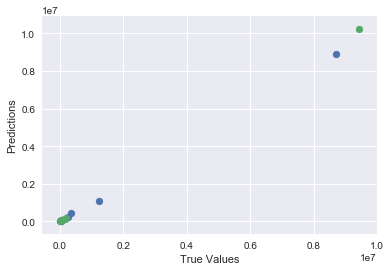

In [22]:
plt.scatter(y_full_50314, predictions_50314)
plt.scatter(y_full_50320, predictions_50320)

plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()


# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [23]:

pd.set_option('display.float_format', lambda x: '%.3f' % x)

#now predict 2016 sales
liquor_full_50314['predictions_2016'] = model_50314.predict(liquor_full_50314[['bottles_sold','state_bottle_retail','sales_1Q16']])
liquor_full_50320['predictions_2016'] = model_50320.predict(liquor_full_50320[['bottles_sold','state_bottle_retail','sales_1Q16']])

liquor_full_50314['zip'] = '50314'
liquor_full_50320['zip'] = '50320'

liquor_full_results = liquor_full_50314.append(liquor_full_50320)


print 'TOP PERFORMING STORES in 50314, 50320'
final_list = liquor_full_results[['predictions_2016','predictions_2015','sales_2015','bottles_2015','volume_liters_2015']].sort_values('predictions_2016', ascending=False)
final_list['avg_price_per_bottle'] = final_list.sales_2015 / final_list.bottles_2015
final_list['avg_price_per_liter'] = final_list.sales_2015 / final_list.volume_liters_2015
final_list['bottle_2016_target'] = final_list.predictions_2016 / final_list.avg_price_per_bottle
final_list['liter_2016_target'] = final_list.predictions_2016 / final_list.avg_price_per_liter

print final_list

TOP PERFORMING STORES in 50314, 50320
              predictions_2016  predictions_2015  sales_2015  bottles_2015  \
store_number                                                                 
2633              10942069.979      10225646.315 9419075.770    578703.000   
4829               9611961.331       8883976.032 8696730.630    517487.000   
2190               1317132.205       1097628.153 1222750.360    106845.000   
3772                509204.561        247772.011  267215.930     34909.000   
4062                422359.014        445103.550  338878.940     43397.000   
4301                248564.500        205077.942  202979.640     21673.000   
3678                111046.265        122806.789  153638.890     12272.000   
4141                 95501.661         81177.417   82718.770      6965.000   
4622                 94353.673         92558.374   72311.770     12562.000   
4849                 88073.733         62897.139   69909.620      4566.000   
4798                 59035

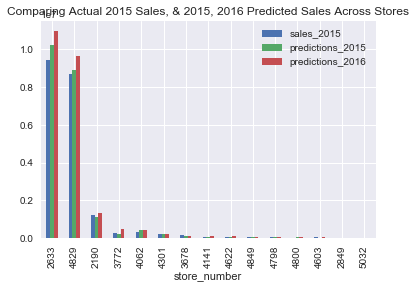

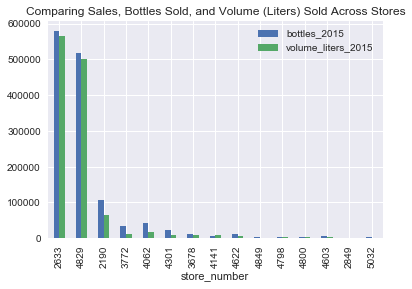

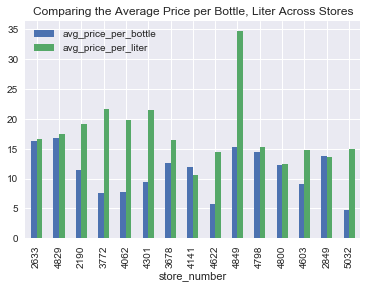

In [24]:
final_list[['sales_2015','predictions_2015','predictions_2016']].plot.bar()
plt.title('Comparing Actual 2015 Sales, & 2015, 2016 Predicted Sales Across Stores')
final_list[['bottles_2015','volume_liters_2015']].plot.bar()
plt.title('Comparing Sales, Bottles Sold, and Volume (Liters) Sold Across Stores')
final_list[['avg_price_per_bottle','avg_price_per_liter']].plot.bar()
plt.title('Comparing the Average Price per Bottle, Liter Across Stores')

In [21]:
liquor_full['category_clean']=''

## set up connection to SQLalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
conn = engine.connect()

## push dataframes into sql tables
liquor_full.to_sql('liquor', engine)

query = 'update liquor set category_clean = (case when category_name like "%VODKA%" then "VODKA" when category_name like "%BRANDIES%" then "BRANDIES" when category_name like "%LIQUEUR%" then "LIQUEURS" when category_name like "%WHISKY%" or category_name like "%WHISKIES%" then "WHISKIES" when category_name like "%TEQUILA%" then "TEQUILA" when category_name like "%RUM%" then "RUM" when category_name like "%SCHNAPPS%" then "SCHNAPPS" when category_name like "%GIN%" then "GIN" when category_name like "%SCOTCH%" then "SCOTCH" when category_name like "%BOURBON%" then "BOURBON" else "OTHER" end)'

conn.execute(query)

liquor_full = pd.read_sql_table('liquor',conn)

## close sql connection
conn.close()


In [18]:
liquor_full['category_clean']=np.NaN
liquor_full.category_name = liquor_full.category_name.fillna('OTHER')
categories = 'VODKA','BRANDIES','LIQUEUR', 'WHISK', 'TEQUILA','RUM', 'SCHNAPPS','GIN','SCOTCH' ,'BOURBON'

for category in categories:
    liquor_full.category_clean[liquor_full.category_name.str.contains(category)] = category

liquor_full.category_clean[liquor_full.category_clean=='WHISK']='WHISKEY'
liquor_full.category_clean = liquor_full.category_clean.fillna('OTHER')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
liquor_full.category_clean.unique()

array(['VODKA', 'BRANDIES', 'LIQUEUR', 'GIN', 'WHISKEY', 'SCOTCH',
       'TEQUILA', 'OTHER', 'RUM', 'BOURBON', 'SCHNAPPS'], dtype=object)

In [22]:
liquor_full.bottle_volume_ml.unique()


array([ 200,  100,  375,  750,  500, 3000, 1750, 1000,  600,  300, 1200,
        800,  900,  150,  400,  850, 2550, 4800, 1125,  250])

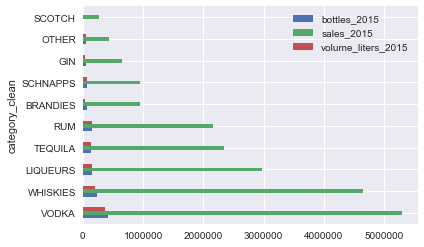

In [23]:
# What are they selling??

aggs = {'sales_2015' : np.sum, 'bottles_2015' : np.sum, 'volume_liters_2015' : np.sum}

top_ten = liquor_full[['category_clean','sales_2015','bottles_2015','volume_liters_2015']].groupby([liquor_full.category_clean]).agg(aggs).sort_values(['sales_2015','bottles_2015'], ascending = False)[0:10]
top_ten['category'] = top_ten.index

top_ten.plot.barh()
plt.show()







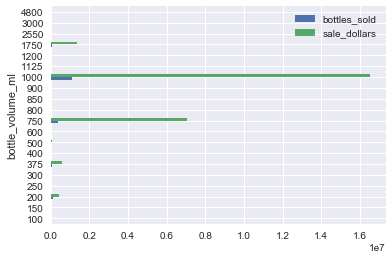

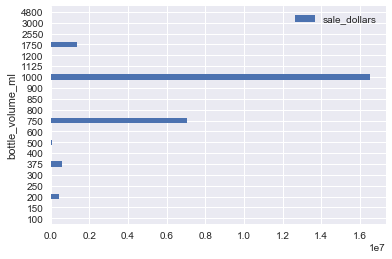

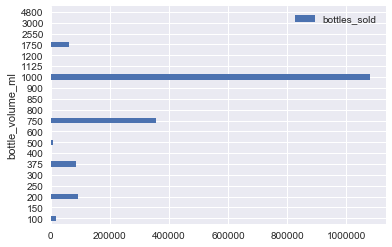

In [25]:
liquor_full.columns


aggs = {'bottles_sold': np.sum, 'sale_dollars' : np.sum}
liquor_full[['bottle_volume_ml',
             'bottles_sold',
             'sale_dollars']].groupby(liquor_full.bottle_volume_ml).agg(aggs).plot.barh()
plt.show()

aggs = {'sale_dollars' : np.sum}
liquor_full[['bottle_volume_ml',
             'sale_dollars']].groupby(liquor_full.bottle_volume_ml).agg(aggs).plot.barh()
plt.show()

aggs = {'bottles_sold' : np.sum}
liquor_full[['bottle_volume_ml',
             'bottles_sold']].groupby(liquor_full.bottle_volume_ml).agg(aggs).plot.barh()
plt.show()


Because of the low population of Iowa and its 'cities,' it's hard to determine more than one particular location where a new store would thrive. Des Moines, Iowa is the state's epicienter of alcohol sales--not many other locations compare. The two highest performing zip codes in terms of sales are both in Des Moines.

Limitations: We don't actually have the sales of the stores; we merely have the amount they're spending on their stock. Using this metric as their sales is risky, as there's definitely a possibility they're not selling everything they're buying. We could look at spending trends and see if they decline anywhere--this could indicate where sales are slow and maybe they're having to markdown prices to rid stock.

## Executive Summary

This report analyzes Iowa Liquor Sales to determine an ideal location for opening a new store based upon the performance of existing stores. The price per bottle and the number of bottles sold help define the stores’ performance. Additionally, other statistics, like average price per liter and average price per bottle, helped solidify the performance variables. Results indicate that the zip code proves to be a great indicator of sales, and that the top-performing zip codes are both in Des Moines: 50314, 50320.

From the numbers available for the fifteen stores in Des Moines, we can see that two stores in particular essentially dominate the market. Aside from their position as the top performers in Des Moines, the margin by which they both outperform the rest of the stores is remarkable. Together, they make up nearly 88% of the liquor sales in these two Des Moines zip codes.

With that aside, the third-best performing store has much more realistic figures for a new competitor to match. To have the second largest share of the Des Moines market, a new store should ideally aim to sell at least 115K bottles,  for  70K liters--while the two most profitable stores will be shooting for upwards of 570K, 550K to meet 2016 sales projections.